In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import jax.numpy as jnp
import cloudpickle

from cellrank.kernels import VelocityKernel
from cellrank.estimators import GPCCA
from moscot.problems.time import TemporalProblem
import moscot.plotting as mtp
import seaborn as sns
from cellrank.kernels import RealTimeKernel

# Original Data loading

In [ ]:
adata = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/adata_JAX_dataset_4.h5ad")
meta = pd.read_csv('/lustre/groups/ml01/workspace/monge_velo/data/df_cell.csv', index_col=0)

adata.obs['celltype'] = pd.Categorical(
    adata.obs['cell_id'].to_frame().merge(meta, on='cell_id', how='inner')['celltype_update']
)

adata.obs['major_trajectory'] = pd.Categorical(
    adata.obs['cell_id'].to_frame().merge(meta, on='cell_id', how='inner')['major_trajectory']
)

adata.obs['day'] = [19.00 if x=='P0' else float(x[1:]) for x in adata.obs['day']]
adata.write("/lustre/groups/ml01/workspace/monge_velo/data/adata_JAX_dataset_4.h5ad")

# Select timepoints

In [6]:
leave_in = [18.75, 19.00]
adata_time = adata[adata.obs['day'].isin(leave_in)].copy()
adata_time.obs['day'] = adata_time.obs['day'].astype('category')

del adata

In [7]:
sc.pp.pca(adata_time)
sc.pp.neighbors(adata_time)
sc.tl.umap(adata_time)

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/umap/spectral.py:342: UserWarning: Exited at iteration 20 with accuracies 
[0.0157958  0.01525468 0.01677432]
not reaching the requested tolerance 1e-08.
Use iteration 21 instead with accuracy 
0.015941600312966573.

  eigenvalues, eigenvectors = scipy.sparse.linalg.lobpcg(
/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/umap/spectral.py:342: UserWarning: Exited postprocessing with accuracies 
[0.0157958  0.01525468 0.01677432]
not reaching the requested tolerance 1e-08.
  eigenvalues, eigenvectors = scipy.sparse.linalg.lobpcg(


### Plot Data

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


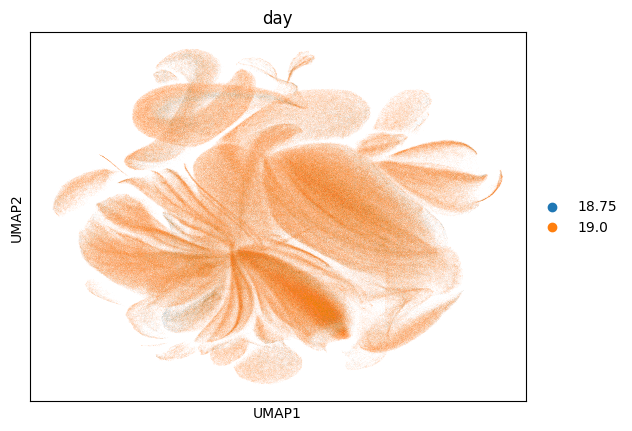

In [8]:
sc.pl.umap(adata_time, color='day')

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


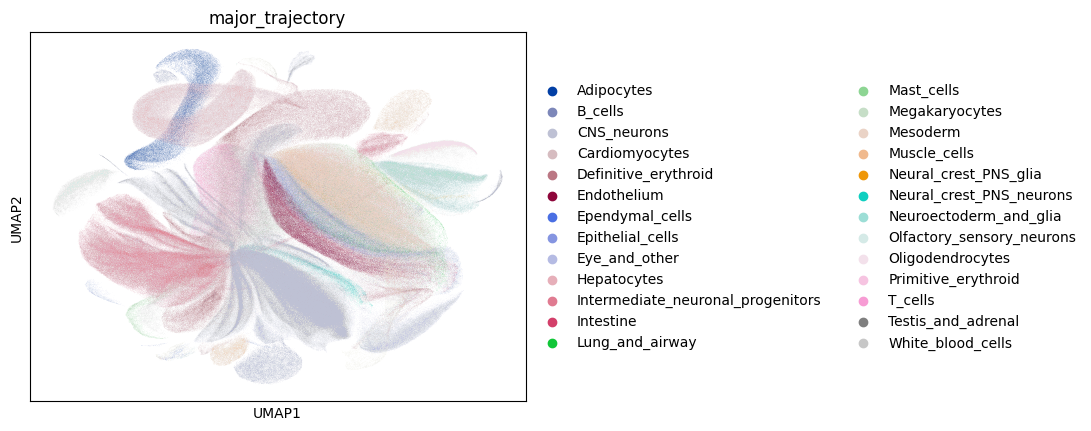

In [9]:
sc.pl.umap(adata_time, color='major_trajectory')

# Subsample

In [10]:
adata_sub = sc.pp.subsample(adata_time, n_obs=10000, copy=True)
sc.pp.pca(adata_sub)
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)

## Plot data

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


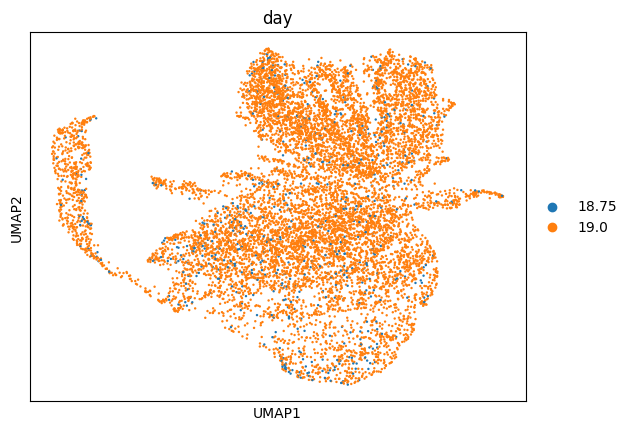

In [11]:
sc.pl.umap(adata_sub, color='day')

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


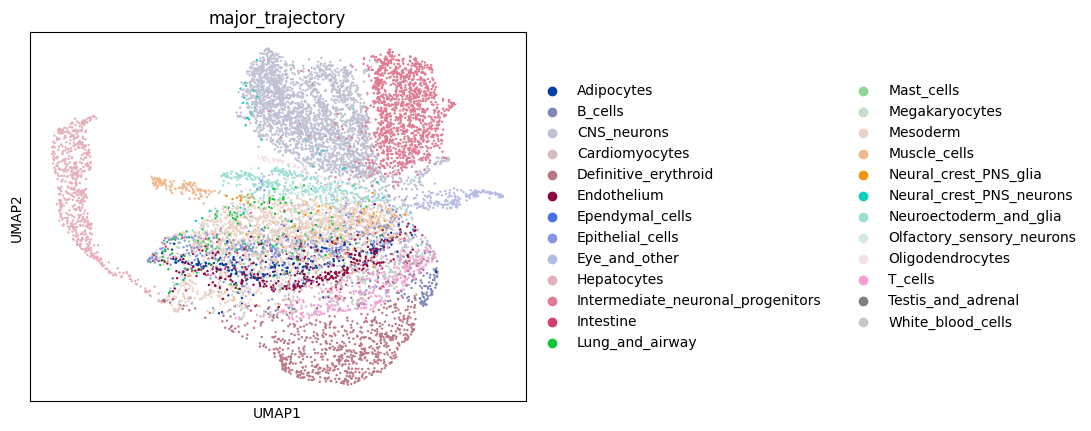

In [12]:
sc.pl.umap(adata_sub, color='major_trajectory')

# Compute temporal problem

In [13]:
tp = TemporalProblem(adata_sub)
tp = tp.prepare("day", joint_attr="X_pca")
tp = tp.solve(epsilon=1e-2)

INFO     Ordering Index(['run_27_PG-09E_S261.TATTGAGGTTTGATGGCCTT-11',                                             
                'run_23_PB-11G_S183.TTCTAAGCTTTTAGATTCCG-11',                                                      
                'run_25_PD-09H_S360.TGTCCTTATTAGTAAGCATA-1-12',                                                    
                'run_25_PC-09G_S263.TGGTCTCCTAGACTCAAGC-1-12',                                                     
                'run_25_PD-02B_S298.GGTTCGAGTTAACTCAATT-1-12',                                                     
                'run_25_PD-03B_S306.GTTCCAGCTATAAGGAGCA-1-12',                                                     
                'run_25_PA-02G_S15.TTCTCTCGTATGGAATTGG-1-12',                                                      
                'run_25_PC-02H_S208.GCGTCGTATTATATACTAA-1-12',                                                     
                'run_25_PC-07F_S246.ATGCTTCCTCGCCTCGAAC-1-12',          

2023-08-09 11:49:44.703378: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


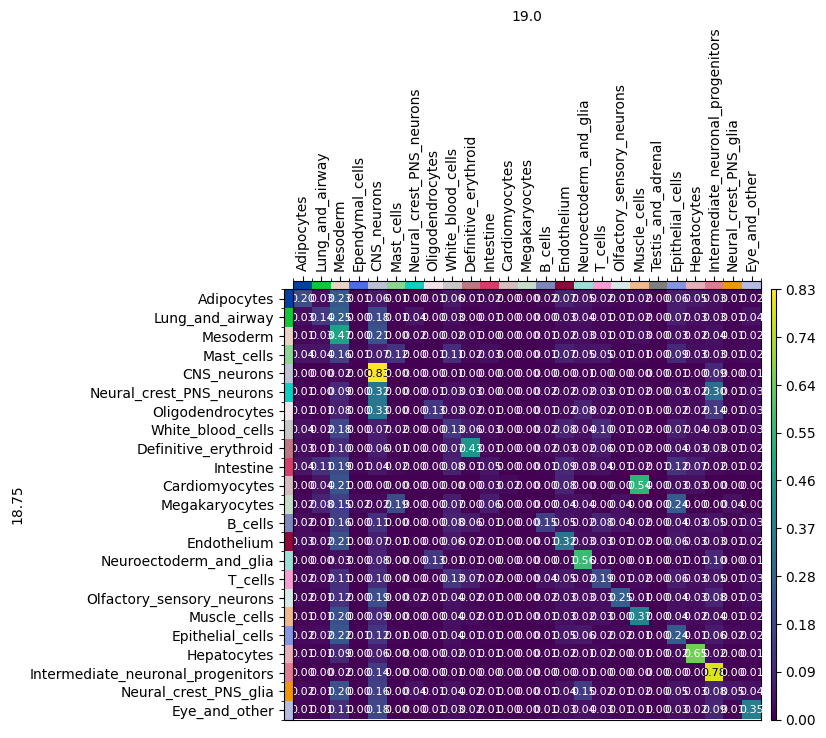

In [14]:
cell_transition = tp.cell_transition(
    source=18.75,
    target=19.00,
    source_groups='major_trajectory',
    target_groups='major_trajectory',
    forward=True,
    key_added="tp_transitions",
)

mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    key="tp_transitions",
)

# Velocities

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52time pair/s]


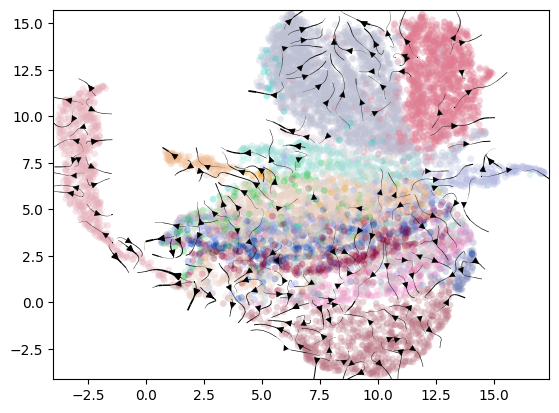

In [15]:
tmk = RealTimeKernel.from_moscot(tp)
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")
try:
    tmk.plot_projection(connectivities=adata_sub.obsp['connectivities'], color='major_trajectory')
except:
    pass

# check subsample

In [16]:
adata_time.obs.celltype.value_counts()/len(adata_time.obs['celltype'])

celltype
GABAergic cortical interneurons           9.752151e-02
Glutamatergic neurons                     8.107931e-02
Fibroblasts                               6.770263e-02
Upper-layer neurons                       6.631554e-02
Definitive early erythroblasts (CD36-)    6.337257e-02
                                              ...     
Neurons (Slc17a8+)                        8.977938e-07
Anterior floor plate                      8.977938e-07
Olfactory pit cells                       4.488969e-07
Primitive erythroid cells                 4.488969e-07
Posterior intermediate mesoderm           4.488969e-07
Name: count, Length: 179, dtype: float64

In [17]:
adata_sub.obs.celltype.value_counts()/10000

celltype
GABAergic cortical interneurons           0.0975
Glutamatergic neurons                     0.0822
Fibroblasts                               0.0704
Definitive early erythroblasts (CD36-)    0.0646
Upper-layer neurons                       0.0643
                                           ...  
Neural crest (PNS neurons)                0.0001
Parathyroid epithelial cells              0.0001
Adipocyte progenitor cells                0.0001
Diencephalon                              0.0001
Name: count, Length: 147, dtype: float64